## Linear regression on a simulated concert dataset to predict concert ticket prices 

### Import necessary libraries and establish DB connection

In [88]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [89]:
db_path = 'concerts.db'
conn = sqlite3.connect(db_path)

### Query data from DB with SQL

1) Create a dictionary with appropriate column names and data queried from corresponding tables of the database

2) Initialise a pandas dataframe which we later populate with data from the dictionary

In [90]:
db_table_names = ('artist', 'customer', 'genre', 'performance', 'ticket', 'ticketpricing')
table_df_dict = dict()

for table_name in db_table_names:
    table_df_dict[table_name] = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)

In [91]:
df = pd.DataFrame()

### Populate the DataFrame with data from the dictionary

1) *populate_with_data()* - implementation involves merging data from different tables of the database (smaller DFs - values of the dictionary) based on the id of other columns
2) split the df into X for features and y for label

In [92]:
def populate_with_data(df):
    df['Ticket Price'] = table_df_dict['ticket']['ticketPrice']
    df['Ticket Category'] = table_df_dict['ticket']['type']

    merged_df = pd.merge(table_df_dict['artist'], table_df_dict['genre'], on='idGenre', how='left')
    merged_df = pd.merge(table_df_dict['performance'], merged_df, on='idArtist', how='left')
    merged_df = pd.merge(table_df_dict['ticket'], merged_df, on='idPerformance', how='left')

    df['Artist'] = merged_df['name_x']
    df['Genre'] = merged_df['genreName']
    df['Performance Name'] = merged_df['name_y']
    df['Performance Date'] = merged_df['date']

    # df['Official Ticket Price'] = table_df_dict['ticket'].merge(
    #     table_df_dict['ticketpricing'][['idPerformance', 'Type', 'price']],
    #     left_on=['idPerformance', 'type'],
    #     right_on=['idPerformance', 'Type'],
    #     how='left'
    # )['price']

In [93]:
populate_with_data(df)
df.head()

,Ticket Price,Ticket Category,Artist,Genre,Performance Name,Performance Date
0,2000,A,ABX,Pop,ABBA,2025-06-18 20:30:00
1,900,C,Adelaire,Pop,Adele,2025-06-19 20:30:00
2,200,D,BamaBeats,Country,Alabama,2025-06-20 20:30:00
3,1000,B,ChillSync,Rock,Coldplay,2025-06-21 20:30:00
4,900,A,Distorto,Metal,Disturbed,2025-06-25 21:30:00


In [94]:
X = df.drop('Ticket Price', axis=1)
y = df['Ticket Price']

### Visualise the data

We can use matplotlib to visualise the relationship of each of the feature columns in X to the label column y

In [95]:
def visualise_data(X, y, y_pred=None):
    for column in X:
        plt.figure(figsize=(12, 3))
        
        if column in ('Artist', 'Performance Name', 'Performance Date'):
            if column == 'Performance Date':
                short_labels = X[column].str[6:7] + X[column].str[8:10]
                short_labels = short_labels.astype(int).sort_values()
            else:
                short_labels = X[column].str[:2]
                short_labels = short_labels.sort_values()
            
            x_positions = range(len(X[column]))
            
            plt.scatter(x_positions, y, color='red')
            if y_pred is not None:
                plt.scatter(x_positions, y_pred, color='blue', marker='X')
            plt.xticks(ticks=x_positions, labels=short_labels)
        else:
            plt.scatter(X[column], y, color='red')
            if y_pred is not None:
                plt.scatter(X[column], y_pred, color='blue', marker='X')
        
        plt.title(f'Price in relation to {column.lower()}')
        plt.xlabel(f'{column}')
        plt.ylabel('Ticket Price')
        
        plt.show()

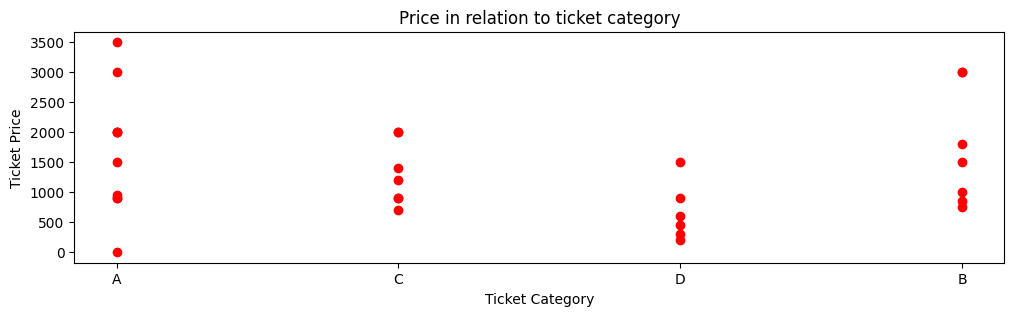

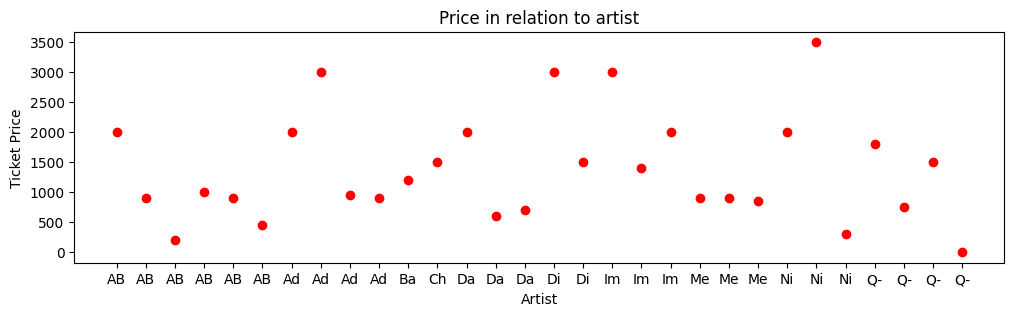

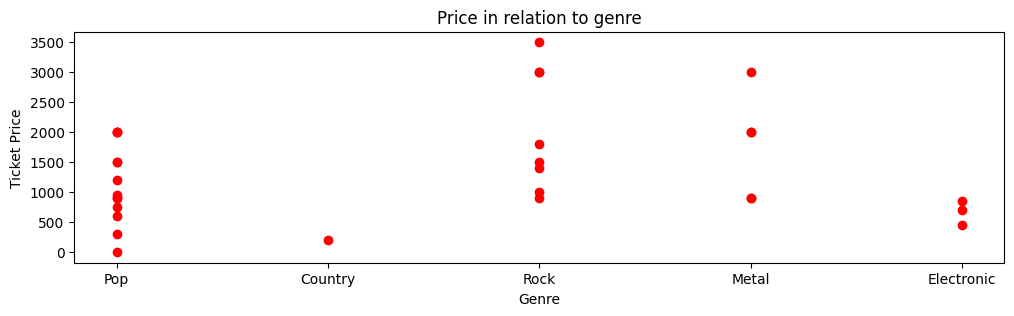

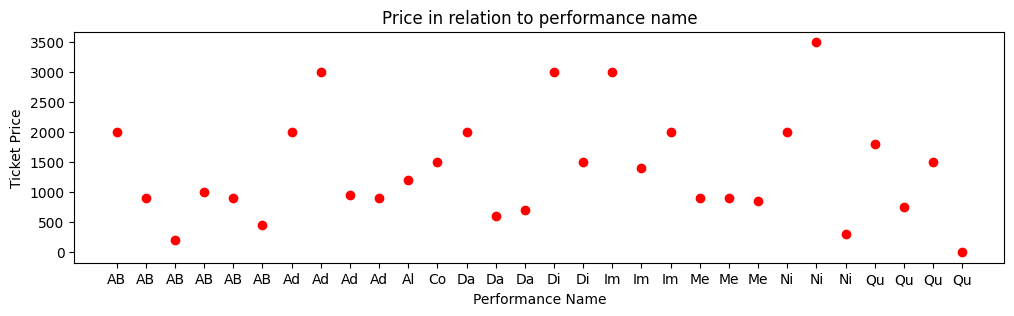

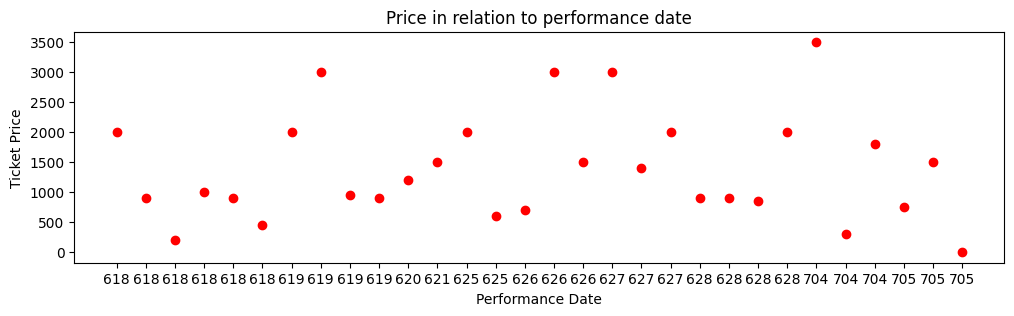

In [96]:
visualise_data(X, y)

### Encode the Performance Date column

Performance Date is represented with the date and time of the performance and looks like $i^{(1)}_{perform. date}$ = 2025-06-18 20:30:00

The date is broken up into 4 parts: (year ignored as examples only contain recent data)
- month
- day
- hour
- minute

Due to the cyclical nature of dates and times, for each of the features two new features are engineered with sin(x) and cos(x) to represent them as a point on a circle. This way, hour 23 is as close to 0 as 0 is to 1


In [97]:
def encode_date(df):
    encd_df = df.copy()
    encd_df['Month'] = df['Performance Date'].str[5:7].astype(int)
    encd_df['Day'] = df['Performance Date'].str[8:10].astype(int)
    encd_df['Hour'] = df['Performance Date'].str[11:13].astype(int)
    encd_df['Minute'] = df['Performance Date'].str[14:16].astype(int)

    date_map = {'Month': 12, 'Day': 30, 'Hour': 24, 'Minute': 60}

    for column, count in date_map.items():
        if column == 'Month' or column == 'Day':
            adjust = 1
        else:
            adjust = 0
        encd_df[f'{column} Sin'] = np.sin((encd_df[column]-adjust) * (2.*np.pi/count))
        encd_df[f'{column} Cos'] = np.cos((encd_df[column]-adjust) * (2.*np.pi/count))

    drop_cols = ['Performance Date', 'Month', 'Day', 'Hour', 'Minute']
    encd_df = encd_df.drop(drop_cols, axis=1)
    return encd_df

### One-hot-encoding for categorical data

- Categorical data is encoded into separate columns with 1s or 0s for each of the unique values it can take - this is known as one-hot-encoding

- In this instance we use sklearn's OneHotEncoder class

In [98]:
# one-hot encoding for ticket category, artist, genre, performance name columns

def one_hot_encode_df(df, cat_cols=['Ticket Category', 
                                'Artist', 'Genre', 
                                'Performance Name']):
    
    one_hot_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe_array = one_hot_enc.fit_transform(df[cat_cols])

    ohe_df = pd.DataFrame(
        ohe_array,
        columns=one_hot_enc.get_feature_names_out(cat_cols),
        index=df.index
    )

    encd_df = df.drop(cat_cols, axis=1)
    encd_df = pd.concat([encd_df, ohe_df], axis=1)
    return encd_df

### Encode X and split X and y into datasets for training and testing

In [99]:
X_encoded = one_hot_encode_df(encode_date(X))
X_encoded.head()

,Month Sin,Month Cos,Day Sin,Day Cos,Hour Sin,Hour Cos,Minute Sin,Minute Cos,Ticket Category_B,Ticket Category_C,...,Genre_Rock,Performance Name_Adele,Performance Name_Alabama,Performance Name_Coldplay,Performance Name_Daft,Performance Name_Disturbed,Performance Name_Imagine,Performance Name_Metallica,Performance Name_Nirvana,Performance Name_Queen
0,0.5,-0.866025,-0.406737,-0.913545,-0.866025,0.500000,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,-0.866025,-0.587785,-0.809017,-0.866025,0.500000,1.224647e-16,-1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,-0.866025,-0.743145,-0.669131,-0.866025,0.500000,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,-0.866025,-0.866025,-0.500000,-0.866025,0.500000,1.224647e-16,-1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.5,-0.866025,-0.951057,0.309017,-0.707107,0.707107,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [113]:
X_train = X_encoded.iloc[0:24]
X_test = X_encoded.iloc[24:30]
y_train = y.iloc[0:24]
y_test = y.iloc[24:30]

### Use cross-validation to see performance difference in linear and polynomial regression with ridge (L2) regularization

Linear model:
- transforming the y label by taking the natural log of 1 + y makes all the predictions positive when transforming results back
- the significant results improvement after the log transformation indicates that there is perhaps an exponential relationship in the data, and taking the log made it linear

Polynomial model:
- regularization prevents overfitting

Ridge regression (regularization) reduced variance and made both models significantly better by reducing overfitting

In [120]:
alphas = np.logspace(-3, 3, num=100)

In [ ]:
log_y_train = np.log1p(y_train)

lin_ridge_cv_model = RidgeCV(alphas=alphas)
lin_ridge_cv_model.fit(X_train, log_y_train)
best_alpha = lin_ridge_cv_model.alpha_

lin_model = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
lin_scores = cross_val_score(lin_model, X_train, log_y_train, scoring='r2', cv=5)
lin_model.fit(X_train, log_y_train)

print(f'Linear model CV R2: {lin_scores.mean()}')
print(f'Best lin model alpha: {best_alpha}')

Linear model CV R2: 0.6731486128941461
Best lin model alpha: 0.07564633275546291


In [123]:
poly_ridge_cv_model = RidgeCV(alphas=alphas)
poly_ridge_cv_model.fit(X_train, y_train)
best_alpha = poly_ridge_cv_model.alpha_

poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    StandardScaler(),
    Ridge(alpha=best_alpha)
)
poly_scores = cross_val_score(poly_model, X_train, y_train, scoring='r2', cv=5)
poly_model.fit(X_train, y_train)

print(f'Polynomial model CV R2: {poly_scores.mean()}')
print(f'Best poly model alpha: {best_alpha}')

Polynomial model CV R2: 0.3847582607126915
Best poly model alpha: 0.8111308307896873


### Make predictions and show the difference between predicted and real values

In [125]:
y_pred_lin = np.expm1(lin_model.predict(X_test))
for pred, real in zip(y_pred_lin, y_test):
    dif = np.abs(pred - real)
    print(f'Predicted price: {pred:.2f} -- Real price: {real} -- Difference: {dif:.2f}')

Predicted price: 3776.15 -- Real price: 3500 -- Difference: 276.15
Predicted price: 388.52 -- Real price: 300 -- Difference: 88.52
Predicted price: 1726.30 -- Real price: 1800 -- Difference: 73.70
Predicted price: 743.82 -- Real price: 750 -- Difference: 6.18
Predicted price: 1438.69 -- Real price: 1500 -- Difference: 61.31
Predicted price: 1961.14 -- Real price: 0 -- Difference: 1961.14


In [126]:
y_pred_poly = poly_model.predict(X_test)
for pred, real in zip(y_pred_poly, y_test):
    dif = np.abs(pred - real)
    print(f'Predicted price: {pred:.2f} -- Real price: {real} -- Difference: {dif:.2f}')

Predicted price: 2668.97 -- Real price: 3500 -- Difference: 831.03
Predicted price: 533.48 -- Real price: 300 -- Difference: 233.48
Predicted price: 1671.24 -- Real price: 1800 -- Difference: 128.76
Predicted price: 726.02 -- Real price: 750 -- Difference: 23.98
Predicted price: 1625.67 -- Real price: 1500 -- Difference: 125.67
Predicted price: 1992.78 -- Real price: 0 -- Difference: 1992.78


### Evaluate both models using MSE and $R^2$ based on the test dataset

In [127]:
mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_poly = mean_squared_error(y_test, y_pred_poly)

r2_lin = r2_score(y_test, y_pred_lin)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Linear model: MSE {mse_lin}, R2 {r2_lin}')
print(f'Polynomial model: MSE {mse_poly}, R2 {r2_poly}')

Linear model: MSE 656568.2957984639, R2 0.5149754548043975
Polynomial model: MSE 791538.3227138895, R2 0.41526948919714735
